In [1]:
## Importamos modulos requeridos
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
tqdm.monitor_interval = 0
import shutil, os
from pandas import Series, DataFrame 
import pandas as pd
import pathlib
pd.set_option('max_rows',100000)
pd.set_option('max_colwidth',100000)
import urllib.request
import webbrowser
import re
import numpy as np
from time import sleep
import subprocess
from subprocess import Popen, PIPE, STDOUT
import shutil
from IPython.display import Image
from IPython.core.display import HTML

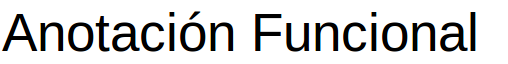

# 1. Anotacion de transcritos
# 2. Gráficos en R<br/>

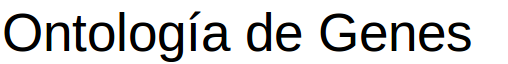

# IMPORTANTE
## Requerimientos para la Ontologia 
>### 1.- go.obo
>### 2.- OWLTools (Map2Slim)
>### 3.- GO slim (goslim_generic)
>### 4.- Proteoma en estudio (IDs Uniprot)
>### 5.- Archivo en formato GAF (Gene Association Format, GOC)
>### 6.- Transcritos
>### 7.- Blast

In [2]:
cd ~/Desktop/data/exp710

C:\Users\SalaD26\Desktop\data\exp710


In [3]:
## creamos dos directorios, uno para las descargas y otro para los resultados
os.makedirs('data',exist_ok=True)
os.makedirs('results',exist_ok=True)
os.makedirs('programs',exist_ok=True)

# 1.- Descargas (go.obo, OWLTools, GO slim y pseudo-GAF)<br/>

In [7]:
if os.path.exists("./data/go.obo"): 
    print ('■■■ El archivo go.obo ya existe, no se descargará de la red')
    if os.path.exists("./data/all_go.txt"):
        print('■■■ El archivo all_go.txt ya existe')
    else:
        ## este aschivo sirve para generar un GAF nuevo
        output4=Popen("grep -e '^id: GO:' -e '^name: ' -e '^namespace: ' -e '.Typedef.' ./data/go.obo | sed 's/id:/#id:/g' | perl -p -e 's/\n/\t/g' | sed 's/.Typedef.*//g' | perl -p -e 's/#/\n/g' | sed 's/id: //g; s/name: //g; s/namespace: //g' | sed '/^$/d' | sed 's/\t$//g' | sed 's/biological_process/P/g; s/molecular_function/F/g; s/cellular_component/C/g' | grep -v -e '\tC\tC' -v -e '\tF\tF' -v -e '\tP\tP' > ./data/all_go.txt",
              shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()        
else:
    ## descarga de la ontologia de genes
    output1=urllib.request.urlretrieve('http://snapshot.geneontology.org/ontology/go.obo','./data/go.obo')
    if os.path.exists("./data/all_go.txt"):
        print('■■■ El archivo all_go.txt ya existe')
    else:
        ## este aschivo sirve para generar un GAF nuevo
        output4=Popen("grep -e '^id: GO:' -e '^name: ' -e '^namespace: ' -e '.Typedef.' ./data/go.obo | sed 's/id:/#id:/g' | perl -p -e 's/\n/\t/g' | sed 's/.Typedef.*//g' | perl -p -e 's/#/\n/g' | sed 's/id: //g; s/name: //g; s/namespace: //g' | sed '/^$/d' | sed 's/\t$//g' | sed 's/biological_process/P/g; s/molecular_function/F/g; s/cellular_component/C/g' | grep -v -e '\tC\tC' -v -e '\tF\tF' -v -e '\tP\tP' > ./data/all_go.txt", shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

■■■ El archivo go.obo ya existe, no se descargará de la red


ValueError: close_fds is not supported on Windows platforms if you redirect stdin/stdout/stderr

In [8]:
if os.path.exists("./programs/owltools"):
    print ('■■■ El programa owltools ya existe, no se descargará de la red')
else: 
    ## descarga de owltools, una herramienta multitarea, una de ellas es hacer GO_slim
    output2=urllib.request.urlretrieve('http://build.berkeleybop.org/userContent/owltools/owltools','./programs/owltools')
    !chmod +x ./programs/owltools

■■■ El programa owltools ya existe, no se descargará de la red


In [9]:
if os.path.exists("./data/goslim_generic.txt"):
    print ('■■■ El archivo goslim_generic.txt ya existe, no se descargará de la red')
else:
    ## descargamos el go-slim desde el Gene Ontology Consortium
    output3=urllib.request.urlretrieve('ftp://ftp.geneontology.org/go/GO_slims/goslim_generic.obo','./data/goslim_generic.obo')
    ## Ahora le hacemos una ligera edicion para obtener tres columnas: GO ID, término y aspecto
    output4=Popen("grep -e '^id: GO:' -e '^name: ' -e '^namespace: ' -e '.Typedef.' ./data/goslim_generic.obo | sed 's/id:/#id:/g' | perl -p -e 's/\n/\t/g' | sed 's/.Typedef.*//g' | perl -p -e 's/#/\n/g' | sed 's/id: //g; s/name: //g; s/namespace: //g' | sed '/^$/d' | sed 's/\t$//g' | sed 's/biological_process/P/g; s/molecular_function/F/g; s/cellular_component/C/g' | grep -v -e '\tC\tC' -v -e '\tF\tF' -v -e '\tP\tP'  > ./data/goslim_generic.txt",
              shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    if os.path.exists("./data/goslim_generic.obo"): os.remove("./data/goslim_generic.obo")

ValueError: close_fds is not supported on Windows platforms if you redirect stdin/stdout/stderr

In [10]:
if os.path.exists("./programs//pseudo-GAF.pl"):
    ## El programa pseudo-GAF crea un archivo en formato GAF para que sea reconodido por OWLTools
    print ('■■■ El programa pseudo-GAF.pl ya existe, no se descargará de la red')
else: 
    ## descarga de owltools, una herramienta multitarea, una de ellas es hacer GO_slim
    output2=urllib.request.urlretrieve('https://raw.githubusercontent.com/eduardo1011/Programas/master/pseudo-GAF.pl','./programs/pseudo-GAF.pl')

# 2.- Transcriptoma en estudio (fasta) 
>## La lista de transcritos se obtuvo del siguiente articulo (*Calanus finmarchicus*)
http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0088589#s2

In [11]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/trasncriptoma.png")

In [ ]:
!sed -i 's/>gi|/>/g; s/|gb|/ /g' 710_trasnscritos.fasta

In [13]:
!head 710_transcritos.fasta

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# 3.- Blastx (traduce nucleotidos a proteinas)

In [14]:
## Nombre de cada columna del resultado del blastx
header=("qacc","Protein_id","qlen","slen","length","score","bitscore","evalue","pident","nident",
                  "mismatch","positive","gaps","gapopen","stitle")

In [22]:
## Ejecutando el programa blastx
!blastx -db C:/Users/SalaD26/Desktop/bigdata/swissprot \
-query 710_transcritos.fasta -evalue 1E-30 \
-outfmt 6 \
-max_target_seqs 1 -max_hsps 1 -out ./results/blastx

In [ ]:
## Ejecutando el programa blastx
!blastx -db C:/Users/SalaD26/Desktop/bigdata/swissprot \
-query 710_transcritos.fasta -evalue 1E-30 \
-outfmt "6 qacc sacc qlen slen length score bitscore evalue pident nident mismatch positive gaps gapopen stitle" \
-max_target_seqs 1 -max_hsps 1 -out ./results/blastx_borrar.tab

In [7]:
## Abrimos el resultado del blastx
blastx=pd.read_csv('./results/blastx',sep='\t',names=header)
blastx.head(3)

,qacc,Protein_id,qlen,slen,length,score,bitscore,evalue,pident,nident,mismatch,positive,gaps,gapopen,stitle
0,1001070759,L1IYN9,347,147,113,546,214,3.000000e-69,98.23,111,2,113,0,0,Uncharacterized protein OS=Guillardia theta CCMP2712 OX=905079 GN=GUITHDRAFT_75159 PE=3 SV=1
1,1001070755,T1IST0,1937,400,79,431,170,1.000000e-43,96.20,76,3,77,0,0,Uncharacterized protein OS=Strigamia maritima OX=126957 PE=3 SV=1
2,1001070753,W5KHW2,1527,512,404,630,247,1.000000e-71,36.88,149,233,234,22,11,Uncharacterized protein OS=Astyanax mexicanus OX=7994 PE=3 SV=1


# 4.- Obtencion de informacion funcional desde QuickGO

In [8]:
## Extraemos el "ID subject" del blastx y creamos una cadena
ids_blastx=Popen("cut -f2 ./results/blastx | perl -p -e 's/\n/%2C/g' | sed 's/%2C$//g'",
          shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read().decode()
print('\n',ids_blastx)


 L1IYN9%2CT1IST0%2CW5KHW2%2CA0A067RA22%2CA0A067RA22%2CA0A2J7R232%2CA0A067RA22%2CA0A2J7Q2W5%2CT1JCR2%2CK1RQW3%2CT1JCR2%2CW5KHR1%2CA0A1L8FIC4%2CT1KGR1%2CA0A2G8KHZ1%2CA0A0P5ZCT5%2CU3J9J1%2CU3J9J1%2CA0A023EI18%2CE1ZYH4%2CA0A067RGE7%2CA0A0T6BCM0%2CA0A0T6BCM0


In [9]:
## Extraemos informacion funcional de los productos de genes desde QuickGO
out=Popen("curl -X GET --header 'Accept:text/tsv' 'https://www.ebi.ac.uk/QuickGO/services/annotation/downloadSearch?geneProductId="+ids_blastx+"' > ./results/quickgo",
          shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
## Abrimos el archivo descargado extraemos las columnas: entry GO-id
go_quickgo=pd.read_csv('./results/quickgo',sep='\t')
go_quickgo.head(3)

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO ASPECT,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,DATE
0,UniProtKB,A0A023EI18,109414702,enables,GO:0000166,F,ECO:0000323,IEA,GO_REF:0000038,UniProtKB-KW:KW-0547,7160,UniProt,NaN,20180714
1,UniProtKB,A0A023EI18,109414702,enables,GO:0005524,F,ECO:0000323,IEA,GO_REF:0000038,UniProtKB-KW:KW-0067,7160,UniProt,NaN,20180714
2,UniProtKB,A0A023EI18,109414702,enables,GO:0005524,F,ECO:0000256,IEA,GO_REF:0000104,UniRule:UR000141827,7160,UniProt,NaN,20180714


In [10]:
## Con un merge asignamos los GO-id a cada transcriito
subject_id=go_quickgo[['GENE PRODUCT ID','GO TERM']].rename(columns={'GENE PRODUCT ID':'Protein_id','GO TERM':'GO'})
transcrito_go=blastx.merge(subject_id,on='Protein_id',how='left')[['qacc','GO']].drop_duplicates()
transcrito_go.head()

,qacc,GO
0,1001070759,GO:0000166
1,1001070759,GO:0005524
3,1001070759,GO:0016740
4,1001070755,GO:0003677
8,1001070755,GO:0003700


In [30]:
## Una forma de ver esta anotación funcional en QuickGO
quickgo_browser=Popen("cut -f2 ./results/blastx | perl -p -e 's/\n/,/g' | sed 's/,$//g'",
          shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read().decode()
#output = Popen("https://www.ebi.ac.uk/QuickGO/annotations?geneProductId="+quickgo_browser+"", shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
webbrowser.open_new("https://www.ebi.ac.uk/QuickGO/annotations?geneProductId="+quickgo_browser+"")

True

# 5.- Creamos un archivo pseudo-GAF compatible con OWLTools (en este paso cada transcrito ya tiene asignado un GO term)

In [12]:
## Para crear un archivo en formato GAF es necesario tener un archivo "gene association"
## Creamos un archivo "gene association" con el siguiente formato
df1=transcrito_go.pivot_table(values='GO',index=['qacc'],aggfunc=sum).reset_index()
df2=df1[['GO']].replace({'GO':';GO'},regex=True).replace({'$':';'},regex=True).replace({'^;':''},regex=True)
df3=pd.concat([df1[['qacc']],df2[['GO']]],axis=1,join='outer')
df3.to_csv('./data/Gene_association.txt',sep='\t',header=None,index=None)
df3.head(3)    

,qacc,GO
0,1001070713,GO:0006338;GO:0070603;
1,1001070714,GO:0006338;GO:0070603;
2,1001070715,GO:0000166;GO:0004672;GO:0004674;GO:0004707;GO:0005524;GO:0016301;GO:0016740;GO:0000165;GO:0006468;GO:0016310;GO:0005622;


In [13]:
## Creamos un archivo pseudo-gaf 
output4=Popen("perl ./programs/pseudo-GAF.pl ./data/all_go.txt ./data/Gene_association.txt > ./data/pseudo_gaf_Transcritos.gaf",
              shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
pseudo_gaf=pd.read_csv('./data/pseudo_gaf_Transcritos.gaf',sep='\t',header=None)
pseudo_gaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,DB,1001070737,1001070737,,GO:0004197,PMID:foo,TAS,,F,1001070737,,protein,taxon:1000,20184820,DB,,
1,DB,1001070737,1001070737,,GO:0008233,PMID:foo,TAS,,F,1001070737,,protein,taxon:1000,20184820,DB,,
2,DB,1001070737,1001070737,,GO:0008234,PMID:foo,TAS,,F,1001070737,,protein,taxon:1000,20184820,DB,,
3,DB,1001070737,1001070737,,GO:0016787,PMID:foo,TAS,,F,1001070737,,protein,taxon:1000,20184820,DB,,
4,DB,1001070737,1001070737,,GO:0097200,PMID:foo,TAS,,F,1001070737,,protein,taxon:1000,20184820,DB,,


 ## 6.- Creando un GO slim usando Map2Slim: una opcion de OWLTools
>### Map2slim usa un fichero GO slim y un fichero .GAF, el script mapea los terminos del .GAF (anotacion completa) en los terminos del  GO slim creando una version corta de la ontologia.

In [14]:
## ejecutamos owltools
!./programs/owltools ./data/go.obo --gaf ./data/pseudo_gaf_Transcritos.gaf --map2slim --idfile ./data/goslim_generic.txt --write-gaf ./data/my_transcritos.gaf > progress
!rm progress

In [15]:
## filtramos filas sin ! (caracteristico de ficheros GAF) y extraemos las columnas 2 y 5 con qacc y GO
output7 = Popen("grep -v '!' ./data/my_transcritos.gaf | cut -f2,5 > ./data/slim_transcritos", shell=True,
                stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
## abrimos el fichero slim y lo asignamos
my_trans_gaf_goslim=pd.read_table('./data/slim_transcritos', names=['Entry','GO']).drop_duplicates().reset_index(drop=True)
print(my_trans_gaf_goslim.count(),'\n')
print(my_trans_gaf_goslim[1:10])

Entry    66
GO       66
dtype: int64 

        Entry          GO
1  1001070737  GO:0007165
2  1001070737  GO:0008219
3  1001070737  GO:0022607
4  1001070751  GO:0016301
5  1001070751  GO:0006464
6  1001070751  GO:0043167
7  1001070735  GO:0043167
8  1001070738  GO:0016491
9  1001070738  GO:0043167


In [16]:
## abrimos el GO slim especifico (yeast en este caso)y lo asignamos
goslim_specific=pd.read_table('./data/goslim_generic.txt',names=['GO','Term','Aspect'])
goslim_specific.head()

,GO,Term,Aspect
0,GO:0000003,reproduction,P
1,GO:0000228,nuclear chromosome,C
2,GO:0000229,cytoplasmic chromosome,C
3,GO:0000278,mitotic cell cycle,P
4,GO:0000902,cell morphogenesis,P


### Ahora le asignaremos el termino a cada transcrito

In [17]:
## asignacion de terminos y aspecto a cada proteina del proteoma en estudio
transcritos_go_term=pd.merge(my_trans_gaf_goslim,goslim_specific,on="GO",how='left').drop_duplicates()#.fillna('N')
transcritos_go_term.head()

,Entry,GO,Term,Aspect
0,1001070737,GO:0008233,peptidase activity,F
1,1001070737,GO:0007165,signal transduction,P
2,1001070737,GO:0008219,cell death,P
3,1001070737,GO:0022607,cellular component assembly,P
4,1001070751,GO:0016301,kinase activity,F


# Resultados
### Ahora extraemos extraemos transcritos y sus categorias<br/>

## Funcion molecular

In [18]:
## Molecular Function
func=transcritos_go_term[['Entry','GO','Term','Aspect']].groupby(['Aspect']).get_group('F')
function=func.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Molecular Function","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
function.to_csv('./results/Molecular_Function.csv',index=None)
function.head()

,GO,Molecular Function,Entry,Value
0,GO:0043167,ion binding,13,13
1,GO:0016301,kinase activity,5,5
2,GO:0003677,DNA binding,3,3
3,GO:0003700,DNA-binding transcription factor activity,3,3
4,GO:0016491,oxidoreductase activity,2,2


In [19]:
## matriz para ver intersecciones entre terminos
up_function=transcritos_go_term[transcritos_go_term.Aspect.str.contains("F")==True]
upset_function=up_function.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_function.to_csv('./results/Molecular_Function_matrix.csv',index=None)
upset_function.head()

GO,Entry,GO:0003677,GO:0003700,GO:0008233,GO:0016301,GO:0016491,GO:0019899,GO:0043167
0,1001070715,0,0,0,1,0,0,1
1,1001070719,1,1,0,0,0,0,0
2,1001070730,0,0,0,0,0,0,1
3,1001070731,0,0,0,0,0,1,1
4,1001070732,0,0,0,0,0,1,1


## Proceso biologico

In [20]:
## Biological Process
pros=transcritos_go_term[['Entry','GO','Term','Aspect']].groupby(['Aspect']).get_group('P')
process=pros.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Biological Process","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
process.to_csv('./results/Biological_Process.csv',index=None)
process.head()

,GO,Biological Process,Entry,Value
0,GO:0006464,cellular protein modification process,7,7
1,GO:0009058,biosynthetic process,3,3
2,GO:0034641,cellular nitrogen compound metabolic process,3,3
3,GO:0006259,DNA metabolic process,2,2
4,GO:0006950,response to stress,2,2


In [21]:
## matriz para ver intersecciones entre terminos
up_process=transcritos_go_term[transcritos_go_term.Aspect.str.contains("P")==True]
upset_process=up_process.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_process.to_csv('./results/Biological_Process_matrix.csv',index=None)
upset_process.head()

GO,Entry,GO:0006259,GO:0006464,GO:0006950,GO:0007165,GO:0008219,GO:0009058,GO:0022607,GO:0034641,GO:0048856,GO:0051276
0,1001070713,0,0,0,0,0,0,0,0,0,1
1,1001070714,0,0,0,0,0,0,0,0,0,1
2,1001070715,0,1,0,1,0,0,0,0,0,0
3,1001070719,0,0,0,0,0,1,0,1,0,0
4,1001070731,1,1,1,0,0,0,0,0,0,0


## Componente celular

In [22]:
## Cellular Component
comp=transcritos_go_term[['Entry','GO','Term','Aspect']].groupby(['Aspect']).get_group('C')
component=comp.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Cellular Component","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
component.to_csv('./results/Cellular_Component.csv',index=None)
component.head()

,GO,Cellular Component,Entry,Value
0,GO:0005634,nucleus,5,5
1,GO:0000228,nuclear chromosome,2,2
2,GO:0005730,nucleolus,2,2
3,GO:0032991,protein-containing complex,2,2
4,GO:0005622,intracellular,1,1


In [23]:
## matriz para ver intersecciones entre terminos
up_component=transcritos_go_term[transcritos_go_term.Aspect.str.contains("C")==True]
upset_component=up_component.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_component.to_csv('./results/Cellular_Component_matrix.csv',index=None)
upset_component.head()

GO,Entry,GO:0000228,GO:0005622,GO:0005634,GO:0005730,GO:0005737,GO:0032991
0,1001070713,1,0,0,0,0,1
1,1001070714,1,0,0,0,0,1
2,1001070715,0,1,0,0,0,0
3,1001070719,0,0,1,0,0,0
4,1001070731,0,0,1,1,0,0


## 5.- Transcritos anotados y no anotados

In [24]:
all_go=pd.read_csv('./data/all_go.txt',sep='\t',names=['GO','Term','Aspect'])
transcritos_anotados=pd.merge(transcrito_go,all_go,on="GO",how='left').drop_duplicates()

In [25]:
## de todas las proteinas sabemos cuantas tienen anotacion en Uniprot
nan=transcritos_anotados[transcritos_anotados['GO'].isnull()].reset_index(drop=True) ## proteinas que no tienen GO
print('Transcritos no anotados: ',nan['qacc'].drop_duplicates().count(),'\n')
print(nan[['qacc']].head())

Transcritos no anotados:  4 

         qacc
0  1001070746
1  1001070743
2  1001070741
3  1001070733


In [26]:
## solo las proteinas que tienen GO
no_nan=transcritos_anotados[transcritos_anotados['GO'].notnull()].reset_index(drop=True) 
print('Transcritos anotados: ',no_nan['qacc'].drop_duplicates().count(),'\n')
print(no_nan[['qacc']].head(),'\n.......')

Transcritos anotados:  19 

         qacc
0  1001070759
1  1001070759
2  1001070759
3  1001070755
4  1001070755 
.......


In [27]:
sin_con=[nan['qacc'].drop_duplicates().reset_index(drop=True).rename(),no_nan['qacc'].drop_duplicates().reset_index(drop=True).rename()]
singo_congo=pd.concat(sin_con, axis=1,ignore_index=False).rename(columns={0:'Without GO',1:'Whith GO'},index=str, inplace=False)
singo_congo.count().to_csv('./results//Anotadas.csv')
singo_congo[['Without GO','Whith GO']].count()

Without GO     4
Whith GO      19
dtype: int64

In [28]:
sin_nan=transcritos_anotados[['qacc','GO','Term','Aspect']].drop_duplicates()
frec=sin_nan.pivot_table(values="GO",index=["qacc"],aggfunc=len,columns="Aspect").reset_index()
frec#.to_csv('./results/Categories_frequences.csv',header=True,index=None)
frec[['F','C','P']].count().to_csv('./results/Total_categories_CFP.csv',header=None)
print('Total de terminos por categoria\n')
print(frec[['F','C','P']].count())

Total de terminos por categoria

Aspect
F    17
C    10
P    15
dtype: int64


In [29]:
## Archivo para generar un diagrama de Venn, intersecciones entre categorias, total de proteinas por categoria
ff=transcritos_anotados[transcritos_anotados.Aspect.str.contains("F")==True]
pp=transcritos_anotados[transcritos_anotados.Aspect.str.contains("P")==True]
cc=transcritos_anotados[transcritos_anotados.Aspect.str.contains("C")==True]
cats=[pp[['qacc']],ff[['qacc']],cc[['qacc']]]
categorias=pd.concat(cats, axis=1, ignore_index=True).rename(columns={0:"Process",1:'Function',2:'Component'},index=str).reset_index(drop=True)
categorias.to_csv('./results/cats.csv',index=None) 
categorias.head()

,Process,Function,Component
0,NaN,1.001071e+09,NaN
1,NaN,1.001071e+09,NaN
2,NaN,1.001071e+09,NaN
3,NaN,1.001071e+09,NaN
4,NaN,1.001071e+09,NaN
